In [1]:
from matplotlib import pyplot as plt
from numpy import*
from matplotlib.pyplot import*
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from NanoParticleTools.inputs.util import combined_energy_level_to_specie_name, combined_energy_level_to_specie_energy_level
from matplotlib.lines import Line2D
from NanoParticleTools.inputs.nanoparticle import Dopant
from NanoParticleTools.inputs.spectral_kinetics import SpectralKinetics

# integrate photons counts over a spectral range
# Args: positive numbers 
import itertools  

def emsInteg(x,y,startWav, endWav):
    sum_int = 0
    for _x, _y in zip(x, y):
        if ((_x>-endWav) and (_x<-startWav)):
            sum_int += _y
    return sum_int
def absInteg(x,y,startWav, endWav):
    sum_int = 0
    for _x, _y in zip(x, y):
        if ((_x<endWav) and (_x>startWav)):
            sum_int += _y
    return sum_int

def populations_to_energy(populations, sk):
    energies = np.hstack([[energy_level.energy for energy_level in dopants.energy_levels] for dopants in sk.dopants])
    
    y_energies = np.multiply(populations, energies)
    return np.sum(y_energies, axis=1)

def get_populations_from_docs(docs):
    x_list = []
    y_list = []
    for doc in docs:
        x_list.append(np.array(doc['data']['output']['x_populations']))
        y_list.append(np.array(doc['data']['output']['y_overall_populations']))
    return x_list, y_list

def average_trajectory_populations(x_list, y_list):
    min_points = min([len(_x) for _x in x_list])
    x = x_list[0][:min_points]
    y = np.mean([_y[:min_points] for _y in y_list], axis=0)
    return x, y

def new_average_tranjectory_populations(x_list,y_list, zero_padding=True, normalize=True):
    num_sample = len(y_list)
    num_t, num_level = max(y_list, key=len).shape
    #x_list = np.array([1e-5 * i for i in range(num_t)])
    x_list = np.array(sorted(x_list, key=len, reverse=True)[0])

    if zero_padding:
        arr = np.zeros((num_sample,num_t,num_level))
    else:
        arr = np.ma.empty((num_sample,num_t,num_level))
        arr.mask = True

    for i, sample in enumerate(y_list):
        if not normalize:
            arr[i,:sample.shape[0], :sample.shape[1]] = sample
        else:
            max_of_rows = sample.max(axis=0)
            print(f'sample {i}: got {np.count_nonzero(max_of_rows)} non zero energy levels: {np.nonzero(max_of_rows)[0]+1}.')
            normalized_array = sample / max_of_rows[None, :]
            arr[i,:sample.shape[0], :sample.shape[1]] = normalized_array
    
    return x_list, arr, arr.mean(axis = 0)
        

def tolerant_mean(x_list,y_list):
    #y_mean=[]
    max_points = max([len(_x) for _x in x_list])
    x = x_list[0][:max_points]

    for i in range(0,len()):
        y_len = len(y_list[i])
        y_mean = np.sum(ytest[:][:y_len], axis=0)
    lens = [len(i) for i in y_list]
    for idx, l in enumerate(y_list):
        y_mean.append(sum(l)/lens[idx])
    return x, np.array(y_mean)

def unique(list1):
  
    # initialize a null list
    unique_list = []
    position_list = []  
    # traverse for all elements
    for x in range(len(list1)):
        # check if exists in unique_list or not
        if list1[x] not in unique_list:
            unique_list.append(list1[x])
            position_list.append(x)
    return position_list, unique_list
        
def plot_spectrum(docs):
    n_docs = 0
    for doc in docs:
        n_docs += 1
        dndt = doc['data']['output']['summary'] # dndt = docs
        accumulated_dndt = {}
        for interaction in dndt:
            interaction_id = interaction[0]
            if interaction_id not in accumulated_dndt:
                accumulated_dndt[interaction_id] = []
            accumulated_dndt[interaction_id].append(interaction)
    avg_dndt = []
    for interaction_id in accumulated_dndt:

        arr = accumulated_dndt[interaction_id][-1][:-4]

        _dndt = [_arr[-4:] for _arr in accumulated_dndt[interaction_id]]

        while len(_dndt) < 1:
            _dndt.append([0 for _ in range(4)])

        mean = np.mean(_dndt, axis=0)
        std = np.std(_dndt, axis=0)
        arr.extend([mean[0], std[0], mean[1], std[1], mean[2], std[2], mean[3], std[3],])
        avg_dndt.append(arr)
    
    x = []
    y = []
    z = []
    dopants = [Dopant(key, val) for key, val in doc['data']['overall_dopant_concentration'].items()]
    for interaction in [_d for _d in avg_dndt if _d[8] == 'Rad']:
        # print(interaction)
        species_id = interaction[2]
        left_state_1 = interaction[4]
        right_state_1 = interaction[6]
        ei = dopants[species_id].energy_levels[left_state_1]
        ef = dopants[species_id].energy_levels[right_state_1]

        de = ef.energy-ei.energy
        wavelength = (299792458*6.62607004e-34)/(de*1.60218e-19/8065.44)*1e9
        
        # print(left_state_1, right_state_1, wavelength)
        x.append(wavelength)
        y.append(interaction[10]) #dndt
        z.append(species_id)
    plt.figure(figsize=(10,4))
    color = ['black','red','green','blue','orange']
    pos, elm = unique(z)
    
    intensity_count = [0]*len(dopants)
    # calculate partition
    for _x, _y, _z in zip(x,y,z):
        if _x <0: # only consider emission
            intensity_count[_z] += _y
    partition = [x/sum(intensity_count) for x in intensity_count]
    for i,j in enumerate(zip(x, y, z)):
        _x=j[0]
        _y=j[1]
        _z=j[2]
        if i in pos:
            mylabel=dopants[z[i]].energy_levels[0].element+': '+"{:.2f}".format(partition[z[i]])
        else:
            mylabel=None
        plt.plot([_x, _x], [0, _y], color=color[_z], label=mylabel)
    plt.ylabel('Relative Intensity', fontsize=18)
    plt.xlabel('Wavelength (nm)', fontsize=18)
    plt.legend(loc="upper left")
    plt.tight_layout()
    return partition, x, y, z
##plt.savefig('Spectra.png')

def get_result_table(doc):
    interaction_id = []
    number_of_sites = []
    species_id_1 = []
    species_id_2 = []
    left_state_1 = []
    left_state_2 = []
    right_state_1 = []
    right_state_2 = []
    interaction_type = []
    rate_coefficient =[]
    dNdT = []
    dNdT_per_atom = []
    occurences = []
    occurences_per_atom = []
    energy_gap = []
    wavelength = []

    summary = doc['data']['output']['summary']
    dopants = [Dopant(key, val) for key, val in docs[0]['data']['overall_dopant_concentration'].items()]

    for i, interaction in enumerate(summary):
        interaction_id.append(interaction[0])
        number_of_sites.append(interaction[1])
        species_id_1.append(interaction[2])
        species_id_2.append(interaction[3])
        left_state_1.append(interaction[4])
        left_state_2.append(interaction[5])
        right_state_1.append(interaction[6])
        right_state_2.append(interaction[7])
        interaction_type.append(interaction[8])
        rate_coefficient.append(interaction[9])
        dNdT.append(interaction[10])
        dNdT_per_atom.append(interaction[11])
        occurences.append(interaction[12])
        occurences_per_atom.append(interaction[13])
        ei = dopants[interaction[2]].energy_levels[interaction[4]]
        ef = dopants[interaction[2]].energy_levels[interaction[6]]
        de = ef.energy-ei.energy
        energy_gap.append(de)
        wav = (299792458*6.62607004e-34)/(de*1.60218e-19/8065.44)*1e9
        wavelength.append(wav)

    df = pd.DataFrame(list(zip(interaction_id,number_of_sites,
                               species_id_1, species_id_2, 
                               left_state_1, left_state_2, right_state_1, right_state_2, 
                               interaction_type, rate_coefficient, dNdT, dNdT_per_atom, 
                               occurences, occurences_per_atom, energy_gap, wavelength)),
                   columns =['interaction_id','number_of_sites',
                               'species_id_1', 'species_id_2', 
                               'left_state_1', 'left_state_2', 'right_state_1', 'right_state_2', 
                               'interaction_type', 'rate_coefficient', 'dNdT', 'dNdT_per_atom', 
                               'occurences', 'occurences_per_atom', 'energy_gap', 'wavelength'])

    # get branching ratio, converging ratio, ...
    left_sum = pd.DataFrame(df.groupby('left_state_1')['dNdT'].sum()).rename(columns={'dNdT':'branchingSum'})
    right_sum = pd.DataFrame(df.groupby('right_state_1')['dNdT'].sum()).rename(columns={'dNdT':'convergingSum'})
    df = pd.merge(df, left_sum, on="left_state_1")
    df = pd.merge(df, right_sum, on="right_state_1")
    df['branching_ratio'] = df['dNdT']/df['branchingSum']
    df['converging_ratio'] = df['dNdT']/df['convergingSum']
    df=df.drop(['branchingSum', 'convergingSum'], axis=1)
    filename = 'Result_Table.csv'
    df.to_csv(filename)
    return df

def get_result_table_dup(doc):
    interaction_id = []
    number_of_sites = []
    species_id_1 = []
    species_id_2 = []
    left_state_1 = []
    left_state_2 = []
    right_state_1 = []
    right_state_2 = []
    interaction_type = []
    rate_coefficient =[]
    dNdT = []
    dNdT_per_atom = []
    occurences = []
    occurences_per_atom = []
    energy_gap = []
    wavelength = []

    summary = doc['data']['output']['summary']
    dopants = [Dopant(key, val) for key, val in docs[0]['data']['overall_dopant_concentration'].items()]

    for i, interaction in enumerate(summary):
        interaction_id.append(interaction[0])
        number_of_sites.append(interaction[1])
        species_id_1.append(interaction[2])
        species_id_2.append(interaction[3])
        left_state_1.append(interaction[4])
        left_state_2.append(interaction[5])
        right_state_1.append(interaction[6])
        right_state_2.append(interaction[7])
        interaction_type.append(interaction[8])
        rate_coefficient.append(interaction[9])
        dNdT.append(interaction[10])
        dNdT_per_atom.append(interaction[11])
        occurences.append(interaction[12])
        occurences_per_atom.append(interaction[13])
        ei = dopants[interaction[2]].energy_levels[interaction[4]]
        ef = dopants[interaction[2]].energy_levels[interaction[6]]
        de = ef.energy-ei.energy
        energy_gap.append(de)
        wav = (299792458*6.62607004e-34)/(de*1.60218e-19/8065.44)*1e9
        wavelength.append(wav)

    df = pd.DataFrame(list(zip(interaction_id,number_of_sites,
                               species_id_1, species_id_2, 
                               left_state_1, left_state_2, right_state_1, right_state_2, 
                               interaction_type, rate_coefficient, dNdT, dNdT_per_atom, 
                               occurences, occurences_per_atom, energy_gap, wavelength)),
                   columns =['interaction_id','number_of_sites',
                               'species_id_1', 'species_id_2', 
                               'left_state_1', 'left_state_2', 'right_state_1', 'right_state_2', 
                               'interaction_type', 'rate_coefficient', 'dNdT', 'dNdT_per_atom', 
                               'occurences', 'occurences_per_atom', 'energy_gap', 'wavelength'])
    
    dup_df = df[df['interaction_type'] == 'ET']
    # get a list of the columns
    col_list = list(dup_df)
    # use this handy way to swap the elements
    col_list[2], col_list[3] = col_list[3], col_list[2]
    col_list[4], col_list[5] = col_list[5], col_list[4]
    col_list[6], col_list[7] = col_list[7], col_list[6]
    # assign back, the order will now be swapped
    dup_df.columns = col_list
    df=df.append(dup_df)
    
    # get branching ratio, converging ratio, ...
    left_sum = pd.DataFrame(df.groupby('left_state_1')['dNdT'].sum()).rename(columns={'dNdT':'branchingSum'})
    right_sum = pd.DataFrame(df.groupby('right_state_1')['dNdT'].sum()).rename(columns={'dNdT':'convergingSum'})
    df = pd.merge(df, left_sum, on="left_state_1")
    df = pd.merge(df, right_sum, on="right_state_1")
    df['branching_ratio'] = df['dNdT']/df['branchingSum']
    df['converging_ratio'] = df['dNdT']/df['convergingSum']
    df=df.drop(['branchingSum', 'convergingSum'], axis=1)
    filename = 'Result_Table_Dup.csv'
    df.to_csv(filename)
    return df

def plot_mechanism(doc, top=50, xmin=None, xmax=None):
    import numpy 
    import matplotlib.pyplot 
    
    df = get_result_table(doc)
    # filter
    filtered = df.sort_values(by=['dNdT'], ascending=False).head(top)
    max_dndt = filtered.dNdT.max()
    min_dndt = filtered.dNdT.min()

    fig, ax =subplots(figsize=(15,15))
    dopants = [Dopant(key, val) for key, val in doc['data']['overall_dopant_concentration'].items()]

    # draw energy lines
    for species in range(len(dopants)):
        species_id = species
        level_count = len(dopants[species_id].energy_levels)
        E = []
        labels = []
        x = [species_id] * len(E)
        for i in range(0,level_count):
            energy = dopants[species_id].energy_levels[i].energy
            label = dopants[species_id].energy_levels[i].label
            E.append(energy)
            labels.append(label)
            ax.hlines(y=energy, xmin=species_id-0.4, xmax=species_id+0.4, linewidth=2, color='black')
            ax.annotate(label, xy=(species_id+0.5,energy), xytext=(0,0), size=10,
                        ha="center",va='center', textcoords="offset points")
            ax.annotate(dopants[species_id].energy_levels[0].element, xy=(species_id,0), xytext=(0,-15), size=20,
                        ha="center",va='top', textcoords="offset points")
        ax.margins(0.1)
        ax.grid(axis='y')

    # set up width bounds
    max_width = 0.02 #max width of arrow line
    min_width = 0.001
    split = (np.log(max_dndt)-np.log(min_dndt))/(max_width-min_width)

    # set up horizontal shift of arrows
    shift_step = 0.03*20/top
    shift = [0] * len(dopants)
    left = 0.4
    head_width = 0.06

    # add Rad
    rad = filtered.loc[(filtered['interaction_type'] == 'Rad')].sort_values(by=['dNdT'], ascending=False)
    for j in range(len(rad)):
        species_id = rad.iloc[j].species_id_1
        initial_level = rad.iloc[j].left_state_1
        initial_energy = dopants[species_id].energy_levels[initial_level].energy
        d_energy = rad.iloc[j].energy_gap
        x_pos = species_id - left
        shift[species_id] += shift_step
        width = min_width + (np.log(rad.iloc[j].dNdT) - np.log(min_dndt))/split
        ax.arrow(x=x_pos+shift[species_id], y=initial_energy , dx=0, dy=d_energy, width=width, length_includes_head=True,
                head_width=head_width, head_length=500, shape='full', overhang=0, 
                color='r')

    # add MD
    md = filtered.loc[(filtered['interaction_type'] == 'MD')].sort_values(by=['dNdT'], ascending=False)
    for j in range(len(md)):
        species_id = md.iloc[j].species_id_1
        initial_level = md.iloc[j].left_state_1
        initial_energy = dopants[species_id].energy_levels[initial_level].energy
        d_energy = md.iloc[j].energy_gap
        x_pos = species_id - left
        shift[species_id] += shift_step
        width = min_width + (np.log(md.iloc[j].dNdT) - np.log(min_dndt))/split
        ax.arrow(x=x_pos+shift[species_id], y=initial_energy , dx=0, dy=d_energy, width=width, length_includes_head=True,
                head_width=head_width, head_length=500, shape='full', overhang=0, 
                color='green')

    # add ET
    et = filtered.loc[(filtered['interaction_type'] == 'ET')].sort_values(by=['dNdT'], ascending=False)
    for j in range(len(et)):
        species_id_1 = et.iloc[j].species_id_1
        species_id_2 = et.iloc[j].species_id_2
        initial_level_1 = et.iloc[j].left_state_1
        initial_energy_1 = dopants[species_id_1].energy_levels[initial_level_1].energy
        d1_energy = et.iloc[j].energy_gap

        initial_level_2 = et.iloc[j].left_state_2
        initial_energy_2 = dopants[species_id_2].energy_levels[initial_level_2].energy
        final_level_2 = et.iloc[j].right_state_2
        final_energy_2 = dopants[species_id_2].energy_levels[final_level_2].energy
        d2_energy = final_energy_2 - initial_energy_2

        x_pos_1 = species_id_1 - left
        x_pos_2 = species_id_2 - left
        shift[species_id_1] += shift_step
        width = min_width + (np.log(et.iloc[j].dNdT) - np.log(min_dndt))/split
        ax.arrow(x=x_pos_1+shift[species_id_1], y=initial_energy_1 , dx=0, dy=d1_energy, width=width, length_includes_head=True,
                head_width=head_width, head_length=500, shape='full', overhang=0, 
                color='blue')
        # annotation
        anno_x1 = x_pos_1+shift[species_id_1]
        anno_y1 = initial_energy_1 + d1_energy/2
        ax.annotate(et.iloc[j].interaction_id, xy=(anno_x1,anno_y1), xytext=(0,0), size=10,
                        ha="center",va='top', textcoords="offset points")
        
        shift[species_id_2] += shift_step
        ax.arrow(x=x_pos_2+shift[species_id_2], y=initial_energy_2 , dx=0, dy=d2_energy, width=width, length_includes_head=True,
                head_width=head_width, head_length=500, shape='full', overhang=0, 
                color='b')
        
        # annotation
        anno_x2 = x_pos_2+shift[species_id_2]
        anno_y2 = initial_energy_2 + d2_energy/2
        ax.annotate(et.iloc[j].interaction_id, xy=(anno_x2,anno_y2), xytext=(0,0), size=10,
                        ha="center",va='top', textcoords="offset points")
        ax.margins(0.1)

    # add NR
    nr = filtered.loc[(filtered['interaction_type'] == 'NR')].sort_values(by=['dNdT'], ascending=False)
    for j in range(len(nr)):
        species_id = nr.iloc[j].species_id_1
        initial_level = nr.iloc[j].left_state_1
        initial_energy = dopants[species_id].energy_levels[initial_level].energy
        d_energy = nr.iloc[j].energy_gap
        x_pos = species_id - left
        shift[species_id] += shift_step/2
        width = min_width + (np.log(nr.iloc[j].dNdT) - np.log(min_dndt))/split
        ax.arrow(x=x_pos+shift[species_id], y=initial_energy , dx=0, dy=d_energy, width=width, length_includes_head=True,
                head_width=head_width, head_length=500, shape='full', overhang=0, 
                color='grey')

    ylabel('Energy (cm$^{-1}$)')
    title('Energy levels')
    plt.ylim([-500, 40000])
    plt.xlim([xmin,xmax])
    ax.set_xticks([])
    ax.yaxis.set_minor_locator(matplotlib.ticker.MaxNLocator(50))



In [3]:
import pandas as pd
import numpy as np
from NanoParticleTools.species_data.species import Dopant
from maggma.stores.mongolike import MongoStore
from matplotlib import pyplot as plt
from bson import ObjectId

data_store = MongoStore.from_launchpad_file('/Users/xiaojing/my_launchpad.yaml', 'test_docs_npmc')
data_store.connect()
#docs = data_store.query()
#docs = data_store.query({'_id': ObjectId('6282c45ffd5dc4986fa1b33e')})
#docs = data_store.query({'data.formula': 'Yb179Nd413Er11'})
docs = data_store.query({'data.excitation_wavelength': 980,
                         #'data.excitation_power': {'$ne' : 0}, #not equal to 0
                         'data.excitation_power': 1e5,
                         'data.input.initial_state_db_args.interaction_radius_bound': 3,
                         #'data.simulation_time': {'$gt':0.009, '$lt':0.011},
                         'data.nanostructure_size': '23A_core-34A_shell-40A_shell',
#                          'data.input.constraints.0.radius': 57,
#                          'data.input.constraints.1.radius': 63,
#                          #'data.input.constraints.2.radius': 50,
                         'data.input.dopant_specifications.0.2': 'Yb',
                         'data.input.dopant_specifications.0.1': {'$gt':0.84, '$lt':0.86},
                          'data.input.dopant_specifications.1.1': {'$gt':0.14, '$lt':0.16},
                          'data.input.dopant_specifications.1.2': 'Er',
#                           'data.input.dopant_specifications.2.1': 0.2,
#                           'data.input.dopant_specifications.2.2': 'Tm',
                         #'data.input.dopant_specifications.3.1': 0.2,
                         #'data.input.dopant_specifications.4.1':0.05,
                         #'data.input.dopant_specifications.0.1': 0.1,
                        })
docs = list(docs)

n_docs = 0
print(f'{len(docs)} simualtion files loaded')


32 simualtion files loaded


In [66]:
import pickle
# write to Pickle
pickle.dump(docs, open( "YbEr_docs_for_spectum.pkl", "wb" ) )

# read from Pickle
#test = pickle.load( open( "pool_based_tuning/100iters_10inits_10trials_beta=1000.pkl", "rb" ) )

In [70]:
spectrum_data = x,y,z
spectrum_data

([975.5951179997659,
  987.2494776875902,
  -975.5951179997659,
  1149.4080413215631,
  964.3986844920051,
  -656.2442551186246,
  -378.581432554615,
  -544.4762038275944,
  -987.2494776875902,
  -1539.6227805231101,
  -407.5084542767677,
  -554.1925271279982,
  -502.0257020682564,
  -842.3763760001348,
  988.6159129508254,
  990.5745378402773,
  -1143.7549993706507,
  -477.89008169642057,
  -2751.747374655366,
  -523.0047049946444,
  -322.38861175761167,
  894.761091579957,
  1037.22123840863,
  -638.3969585991829,
  -1957.3008337243296,
  -451.2771316168419,
  -347.6153217053429,
  -711.4292799870234,
  -316.1508049161429,
  -1135.8302998066333,
  -364.6918293033406,
  -385.96047549104946,
  -1214.016020334782,
  1112.2066465907685,
  1022.584104662808,
  -397.84563196728067,
  -618.3051975204106,
  -753.909074147889,
  -243.02743722501276,
  -894.761091579957,
  -342.10913306526174,
  -492.5549187024727,
  -2885.9595842705917,
  1333.3133279330134,
  1050.7355216452243,
  -404.63925

In [71]:
pickle.dump(spectrum_data, open( "YbEr_spectum.pkl", "wb" ) )


(-200.0, -900.0)

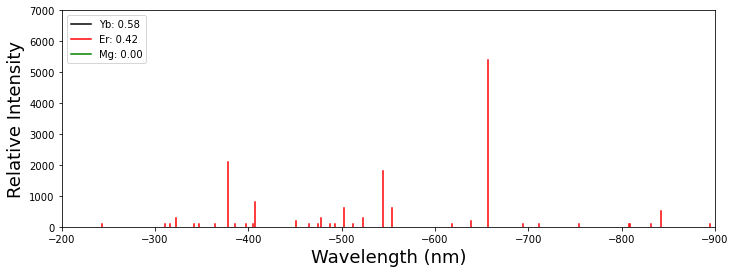

In [12]:
plot_spectrum(docs)
#plt.ylim(bottom=0)
plt.ylim([0,7000])
plt.xlim([-200,-900])
# plt.axvspan(-2000, 0, color='#00A1FF', alpha=0.19)
# plt.axvspan(0, 2000, color='#F8CF6A', alpha=0.19)

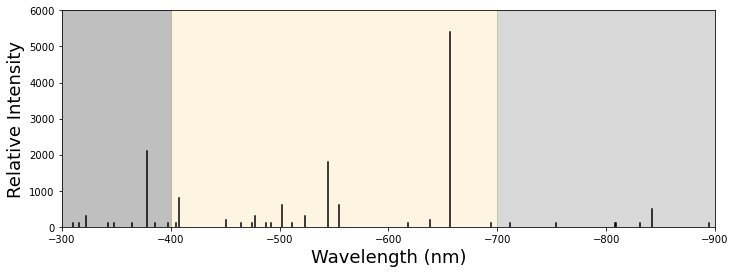

In [40]:
n_docs = 0
for doc in docs:
    n_docs += 1
    dndt = doc['data']['output']['summary'] # dndt = docs
    accumulated_dndt = {}
    for interaction in dndt:
        interaction_id = interaction[0]
        if interaction_id not in accumulated_dndt:
            accumulated_dndt[interaction_id] = []
        accumulated_dndt[interaction_id].append(interaction)
avg_dndt = []
for interaction_id in accumulated_dndt:

    arr = accumulated_dndt[interaction_id][-1][:-4]

    _dndt = [_arr[-4:] for _arr in accumulated_dndt[interaction_id]]

    while len(_dndt) < 1:
        _dndt.append([0 for _ in range(4)])

    mean = np.mean(_dndt, axis=0)
    std = np.std(_dndt, axis=0)
    arr.extend([mean[0], std[0], mean[1], std[1], mean[2], std[2], mean[3], std[3],])
    avg_dndt.append(arr)

x = []
y = []
z = []
dopants = [Dopant(key, val) for key, val in doc['data']['overall_dopant_concentration'].items()]
for interaction in [_d for _d in avg_dndt if _d[8] == 'Rad']:
    # print(interaction)
    species_id = interaction[2]
    left_state_1 = interaction[4]
    right_state_1 = interaction[6]
    ei = dopants[species_id].energy_levels[left_state_1]
    ef = dopants[species_id].energy_levels[right_state_1]

    de = ef.energy-ei.energy
    wavelength = (299792458*6.62607004e-34)/(de*1.60218e-19/8065.44)*1e9

    # print(left_state_1, right_state_1, wavelength)
    x.append(wavelength)
    y.append(interaction[10]) #dndt
    z.append(species_id)
plt.figure(figsize=(10,4))
color = ['red','black','green','blue','orange']
pos, elm = unique(z)

intensity_count = [0]*len(dopants)
# calculate partition
for _x, _y, _z in zip(x,y,z):
    if _x <0: # only consider emission
        intensity_count[_z] += _y
partition = [x/sum(intensity_count) for x in intensity_count]
for i,j in enumerate(zip(x, y, z)):
    _x=j[0]
    _y=j[1]
    _z=j[2]
    if i in pos:
        mylabel=dopants[z[i]].energy_levels[0].element+': '+"{:.2f}".format(partition[z[i]])
    else:
        mylabel=None
    plt.plot([_x, _x], [0, _y], color=color[_z], label=mylabel)
plt.ylabel('Relative Intensity', fontsize=18)
plt.xlabel('Wavelength (nm)', fontsize=18)
#plt.legend(loc="upper left")
plt.tight_layout()

plt.ylim([0,6000])
plt.xlim([-300,-900])
plt.axvspan(-200, -400, color='grey', alpha=0.5)
plt.axvspan(-400, -700, color='#F8CF6A', alpha=0.19)
plt.axvspan(-700, -1000, color='grey', alpha=0.3)

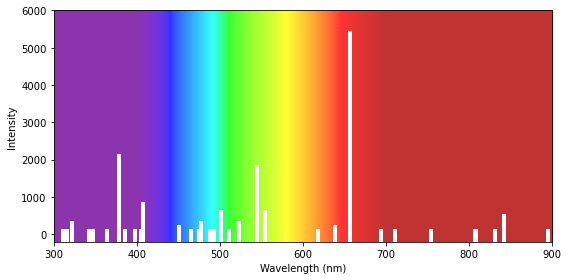

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

baseline = -200

def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(400,700)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(8,4), tight_layout=True)

wavelengths = np.linspace(300, 900, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)
#spectrum  = 6000+0*wavelengths
#plt.plot(wavelengths, spectrum, color='darkred')

y_c = np.linspace(baseline, 6000, 100)
X,Y = np.meshgrid(wavelengths, y_c)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y_c), np.max(y_c))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto',alpha=0.8)
for i,j in enumerate(zip(x, y, z)):
    _x=-j[0]
    _y=j[1]
    _z=j[2]
    if i in pos:
        mylabel=dopants[z[i]].energy_levels[0].element+': '+"{:.2f}".format(partition[z[i]])
    else:
        mylabel=None
    plt.plot([_x, _x], [baseline, _y], color='w', label=mylabel, linewidth = 4)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.ylim([baseline,6000])
plt.xlim([300,900])

# Set the borders to a given color...
# axs.tick_params(color='white', labelcolor='white')
# for spine in axs.spines.values():
#     spine.set_edgecolor('white')
#plt.fill_between(wavelengths, spectrum, 8, color='w')
#plt.savefig('WavelengthColors.png', dpi=200)

plt.show()

In [77]:
plt.savefig('spectrum_color_bcg.pdf') 

<Figure size 432x288 with 0 Axes>